# 04a_modality_usage_ct.ipynb  
**Diagnostic Modality Analysis – MRI Usage by Demographics and Procedure Type**

---

### **Aim**
This notebook examines **Magnetic Resonance Imaging (MRI)** patterns across patient demographics (`age_band`, `gender`) and anatomical groupings (e.g. **brain**, **spine**, **MSK**, **pelvis**).

Following the structure of `04a`–`04d`, this notebook provides:
- Frequency tables of common MRI procedures  
- Crosstab outputs by `age_band × anatomical_group`  
- Age distribution plots for high-volume MRI groups  
- Referral and patient source matrix exploration  

---

### **Purpose**
To support demand modelling for MRI capacity planning by identifying demographic variation in usage and highlighting elective diagnostic trends.

---

### **Output**
- Top anatomical groupings for MRI  
- Age-demographic plots and summaries  
- Cross-tabulations for referral and patient pathways  
- Prepared input for geospatial demand mapping by LSOA  

---

### **Notes**
- Excludes oncology-specific fields (elective/general focus)  
- Uses `procedure_name → anatomical_group` mapping  
- Complements the full 04x notebook series, especially 04c (Endoscopy) and 04d (CT)  

---

Imports & Raw-Folder Ingestion

In [1]:
# ---------------------------------------------------
# 0 – Imports & Raw-Folder Ingestion
# ---------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib as plt
import os
import glob
import re
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# ----------- 1A. Point to your raw folder OR hard-code the list ----------
raw_dir   = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"
csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))

if not csv_files:
    raise FileNotFoundError("csv_files list is empty – check raw_dir or paths")

print(f"Detected {len(csv_files)} files")

# ----------- canonical 23-column schema from the SQL query ---------------
expected_cols = [
    'icb_code','icb_name','lsoa_code','nhs_region',
    'site_code','site_name','provider_code','provider_name',
    'activity_month','financial_year','financial_month','test_date',
    'age','sex','modality','sub_modality','procedure_name',
    'referral_type','patient_source','cancer_flag','subcancer_flag',
    'referring_org_code','referring_org_name'
]

dfs, meta = [], []
for fp in csv_files:
    peek = pd.read_csv(fp, nrows=5)
    if not set(expected_cols).issubset(peek.columns):
        print(f" {os.path.basename(fp)} – no header found, re-loading with names")
        df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
    else:
        df_tmp = pd.read_csv(fp, low_memory=False)

    df_tmp = df_tmp.dropna(axis=1, how='all')
    df_tmp.columns = df_tmp.columns.str.strip().str.lower()
    df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
    for col in (set(expected_cols) - set(df_tmp.columns)):
        df_tmp[col] = pd.NA
    df_tmp = df_tmp[expected_cols]
    dfs.append(df_tmp)

    meta.append({
        "file": os.path.basename(fp),
        "rows": len(df_tmp),
        "cols": df_tmp.shape[1],
        "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
    })

meta_df = pd.DataFrame(meta)
display(meta_df.style.set_caption("Loaded files – rows / cols / size"))

df = pd.concat(dfs, ignore_index=True)
print(f"Combined shape: {df.shape}")  # expect ~4 M × 23

# Basic type coercion
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["test_date"] = pd.to_datetime(df["test_date"], errors="coerce")
df["activity_month"] = pd.to_datetime(
    df["activity_month"].astype(str), format="%Y%m", errors="coerce"
)


Detected 7 files
 2024_NHS_SW_Somerset_ICB_11X.csv – no header found, re-loading with names
 2024_NHS_SW_Cornwall_ICB_11N.csv – no header found, re-loading with names
 2024_NHS_SW_Gloucestershire_ICB_11M.csv – no header found, re-loading with names
 2024_NHS_SW_Dorset_ICB_11J.csv – no header found, re-loading with names
 2024_NHS_SW_Devon_ICB_15N.csv – no header found, re-loading with names
 2024_NHS_SW_BSW_ICB_92G.csv – no header found, re-loading with names
 2024_NHS_SW_BNSSG_ICB_15C.csv – no header found, re-loading with names


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000


Combined shape: (3989252, 23)


Clean & Bucket Patient Source

In [2]:
df["patient_source"] = (
    df["patient_source"]
      .astype(str).str.strip().str.lower()
      .str.replace(r"\(this health care provider\)", "", regex=True)
      .str.replace(r"\s+-\s+", " – ", regex=True)
      .replace({"nan": np.nan})
      .fillna("unknown")
)

bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency",
    r"gp direct|gp ":             "GP",
    r"inpatient":                 "Inpatient",
    r"outpatient":                "Outpatient",
    r"elective|planned":          "Elective",
}
def ps_bucket(txt: str) -> str:
    for pat, lab in bucket_map.items():
        if re.search(pat, txt):
            return lab
    return "Other/Unknown"

df["ps_bucket"] = df["patient_source"].apply(ps_bucket)
df["ps_bucket"].value_counts(dropna=False)


ps_bucket
Outpatient       1428095
GP                923522
Emergency         832850
Inpatient         695375
Other/Unknown     109410
Name: count, dtype: int64

ONS 5-Year Age Bands

In [3]:
# Define ONS-style bands
bands = pd.DataFrame({
    "lower":[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper":[4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label":["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
             "40-44","45-49","50-54","55-59","60-64","65-69","70-74",
             "75-79","80-84","85+"]
})
bins   = bands["lower"].tolist() + [np.inf]
labels = bands["label"]

# Keep only whole-number ages
df = df[df["age"].notna() & (df["age"] % 1 == 0)]
df["age"] = df["age"].astype(int)
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels, right=True)


Columns to Summarise

In [4]:
for col in ['modality', 'sub_modality', 'procedure_name']:
    print(f"\n Top 100 values for: {col}")

    vc = df[col].value_counts(dropna=False)
    total = vc.sum()

    top100 = vc.head(100).reset_index()
    top100.columns = [col, "Count"]
    top100["% of Total"] = (top100["Count"] / total * 100).round(2)

    display(
        top100.style
            .set_caption(f"Top 100: {col} (Count and %)")
            .format({"Count": "{:,}", "% of Total": "{:.2f}%"})
            .background_gradient(cmap="Blues", subset=["Count"])
    )

    print(f"Unique values in {col!r}: {df[col].nunique(dropna=False)}")


 Top 100 values for: modality


,modality,Count,% of Total
0,Plain radiography (procedure),"1,561,194",39.14%
1,Diagnostic ultrasonography (procedure),"782,294",19.61%
2,Computerized axial tomography (procedure),"647,463",16.23%
3,nan,"510,252",12.79%
4,Magnetic resonance imaging (procedure),"324,885",8.14%
5,Fluoroscopy (procedure),"92,541",2.32%
6,Nuclear medicine procedure (procedure),"29,358",0.74%
7,Positron emission tomography (procedure),"24,039",0.60%
8,Endoscopy (procedure),"7,174",0.18%
9,Single photon emission computerized tomography (procedure),"3,563",0.09%


Unique values in 'modality': 12

 Top 100 values for: sub_modality


,sub_modality,Count,% of Total
0,nan,"3,897,393",97.70%
1,X-ray photon absorptiometry (procedure),"42,811",1.07%
2,Diagnostic Doppler ultrasonography (procedure),"26,540",0.67%
3,Positron emission tomography with computed tomography (procedure),"20,614",0.52%
4,Single photon emission computed tomography with computed tomography (procedure),"1,830",0.05%


Unique values in 'sub_modality': 5

 Top 100 values for: procedure_name


,procedure_name,Count,% of Total
0,Plain chest X-ray (procedure),"386,207",9.68%
1,Plain chest X-ray (procedure) (399208008),"298,780",7.49%
2,Computed tomography of entire head (procedure),"92,626",2.32%
3,Computed tomography of entire head (procedure) (408754009),"69,122",1.73%
4,Ultrasonography of abdomen (procedure),"50,641",1.27%
5,Ultrasound scan for fetal growth (procedure),"45,361",1.14%
6,"Computed tomography of thorax, abdomen and pelvis with contrast (procedure)","45,150",1.13%
7,Transthoracic echocardiography (procedure) (433236007),"41,864",1.05%
8,"Computed tomography of thorax, abdomen and pelvis with contrast (procedure) (433761009)","35,316",0.89%
9,Computed tomography of abdomen and pelvis with contrast (procedure),"34,668",0.87%


Unique values in 'procedure_name': 3759


In [12]:
# ---------------------------------------------------
# Step 1 – Filter for MRI modality & check dimensions
# ---------------------------------------------------
df_mri = df[df["modality"] == "Magnetic resonance imaging (procedure)"].copy()

print(f"MRI subset shape: {df_mri.shape}")              # rows × columns

print("\nTop 10 sub_modalities:")
display(df_mri["sub_modality"].value_counts(dropna=False).head(10))

print("\nTop 10 procedure names:")
display(df_mri["procedure_name"].value_counts(dropna=False).head(10))

# ── NEW: total count of unique procedure names ─────────────────────────
print(f"\nTotal unique MRI procedure names: {df_mri['procedure_name'].nunique()}")


MRI subset shape: (324885, 25)

Top 10 sub_modalities:


sub_modality
NaN    324885
Name: count, dtype: int64


Top 10 procedure names:


procedure_name
Magnetic resonance imaging of head (procedure)                                   33189
Magnetic resonance imaging of head (procedure) (241601008)                       25026
Magnetic resonance imaging of lumbar and sacral spine (procedure) (433141005)    17952
Magnetic resonance imaging of lumbar and sacral spine (procedure)                15007
Magnetic resonance imaging of head with contrast (procedure) (432874000)         10343
Magnetic resonance imaging of head with contrast (procedure)                      8855
Magnetic resonance imaging of cervical spine (procedure)                          8694
Magnetic resonance imaging of cervical spine (procedure) (241646009)              8566
Magnetic resonance imaging of spine (procedure)                                   7742
Magnetic resonance imaging of spine (procedure) (241645008)                       7367
Name: count, dtype: int64


Total unique MRI procedure names: 568


In [13]:
# ---------------------------------------------------
# Step 2 – MRI procedure breakdown by age_band (Top 25)
# ---------------------------------------------------

# Step 1: Cross-tab – procedure_name × age_band
mri_age_procedure = pd.crosstab(
    df_mri["procedure_name"],
    df_mri["age_band"]
)

# Step 2: Add total column and sort
mri_age_procedure["Total"] = mri_age_procedure.sum(axis=1)
mri_age_procedure_sorted = mri_age_procedure.sort_values("Total", ascending=False)

# Step 3: Get top 25 procedures
mri_top25 = mri_age_procedure_sorted.head(25)

# Step 4: Add % of all MRI scans
total_mri = df_mri.shape[0]
mri_top25["% of Total"] = mri_top25["Total"] / total_mri * 100

# Step 5: Exclude 'Total' and '% of Total' from heatmap
heatmap_cols = mri_top25.columns.difference(["Total", "% of Total"])

# Step 6: Display styled table
display(
    mri_top25.style
        .set_caption("Top 25 MRI Procedures by Age Band (Counts + % of Total)")
        .background_gradient(cmap="Greens", subset=heatmap_cols, axis=1)
        .format("{:,.0f}", na_rep="–", subset=mri_top25.columns.difference(["% of Total"]))
        .format("{:.2f}%", na_rep="–", subset=["% of Total"])
)

# Final print
print(f"Total unique MRI procedures: {df_mri['procedure_name'].nunique()}")
print(f"Top 25 procedures shown. Percent is relative to all {total_mri:,} MRI scans.")


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_3860/2892574432.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mri_top25["% of Total"] = mri_top25["Total"] / total_mri * 100


age_band,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+,Total,% of Total
procedure_name,,,,,,,,,,,,,,,,,,,,
Magnetic resonance imaging of head (procedure),487,730,954,980,977,"1,312","1,595","1,695","1,913","1,957","2,361","2,880","2,891","2,629","2,890","3,112","2,008","1,522","32,893",10.12%
Magnetic resonance imaging of head (procedure) (241601008),451,488,584,807,992,"1,190","1,530","1,598","1,554","1,527","1,847","2,053","2,019","1,845","1,850","2,104","1,363",930,"24,732",7.61%
Magnetic resonance imaging of lumbar and sacral spine (procedure) (433141005),15,34,109,276,461,763,"1,116","1,343","1,399","1,325","1,641","1,777","1,791","1,529","1,517","1,547",858,444,"17,945",5.52%
Magnetic resonance imaging of lumbar and sacral spine (procedure),11,35,119,232,355,563,928,"1,118","1,094","1,115","1,362","1,575","1,442","1,278","1,326","1,324",739,386,"15,002",4.62%
Magnetic resonance imaging of head with contrast (procedure) (432874000),122,157,180,203,231,275,410,498,547,644,894,"1,187","1,092","1,156","1,194",959,390,180,"10,319",3.18%
Magnetic resonance imaging of head with contrast (procedure),69,107,152,158,175,230,336,389,470,555,671,946,900,986,"1,005",983,467,233,"8,832",2.72%
Magnetic resonance imaging of cervical spine (procedure),13,28,48,87,162,293,450,572,716,735,"1,014","1,039",945,695,704,651,368,167,"8,687",2.67%
Magnetic resonance imaging of cervical spine (procedure) (241646009),19,27,51,101,181,344,551,634,794,799,"1,047","1,025",832,670,532,551,275,132,"8,565",2.64%
Magnetic resonance imaging of spine (procedure),91,140,276,223,205,289,352,456,471,509,575,710,655,653,680,720,445,252,"7,702",2.37%


Total unique MRI procedures: 568
Top 25 procedures shown. Percent is relative to all 324,885 MRI scans.


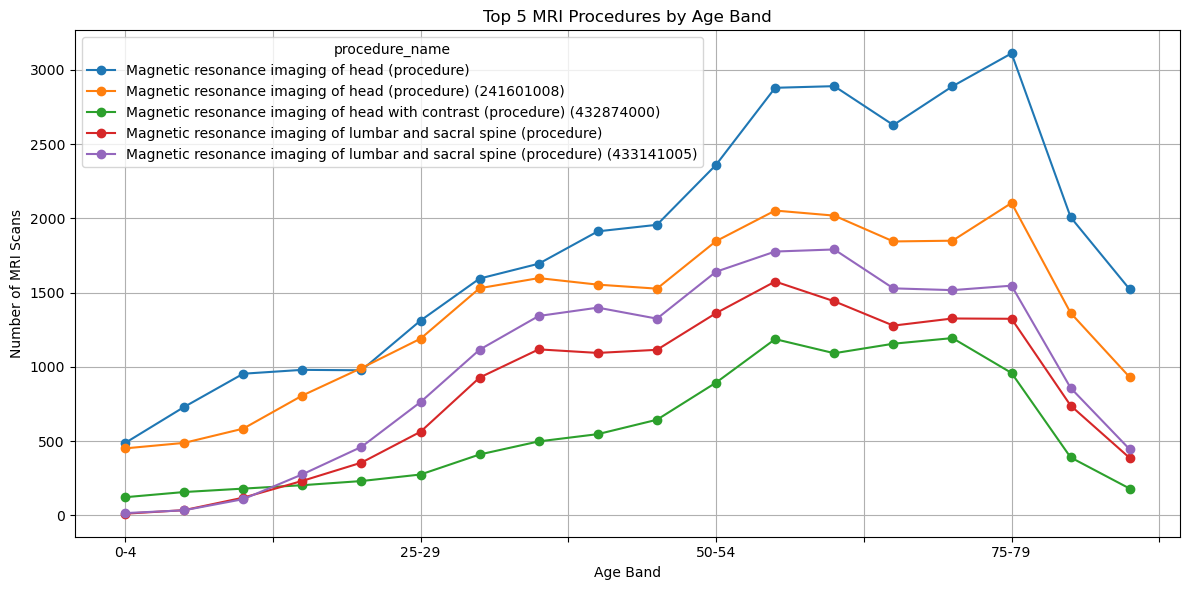

In [15]:
# ---------------------------------------------------
# Step 3 – Line plot: Top 5 MRI procedures by age_band
# ---------------------------------------------------
import matplotlib.pyplot as plt  

#   Identify top-5 MRI procedures overall
top_5_mri_procedures = (
    df_mri["procedure_name"]
      .value_counts()
      .head(5)
      .index
)

#   Build crosstab for just those five
mri_subset = df_mri[df_mri["procedure_name"].isin(top_5_mri_procedures)]

mri_plot = pd.crosstab(
    mri_subset["age_band"],
    mri_subset["procedure_name"]
).sort_index()        # keeps age bands in logical order

#   Plot
mri_plot.plot(
    kind="line",
    marker="o",
    figsize=(12, 6),
    title="Top 5 MRI Procedures by Age Band"
)

plt.xlabel("Age Band")
plt.ylabel("Number of MRI Scans")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# ---------------------------------------------------
# Step 4 – MRI Procedure vs Patient Source (sorted)
# ---------------------------------------------------

#   Crosstab: procedure_name × ps_bucket
mri_ps = pd.crosstab(
    df_mri["procedure_name"],
    df_mri["ps_bucket"]
)

#   Add a total column, sort, then drop helper
mri_ps["Total"] = mri_ps.sum(axis=1)
mri_ps_sorted = mri_ps.sort_values("Total", ascending=False).drop(columns="Total")

#   Display the top 25 procedures
display(
    mri_ps_sorted.head(25).style
        .set_caption("Top 25 MRI Procedures by Patient Source")
        .background_gradient(cmap="Oranges")
        .format(na_rep="–")
)

#   Quick summary prints
print("Patient-source breakdown complete.")
print(f"Unique ps_buckets: {df_mri['ps_bucket'].nunique()}")
print(f"Total unique MRI procedure types: {df_mri['procedure_name'].nunique()}")


ps_bucket,Emergency,GP,Inpatient,Other/Unknown,Outpatient
procedure_name,,,,,
Magnetic resonance imaging of head (procedure),912,3679,9035,933,18630
Magnetic resonance imaging of head (procedure) (241601008),732,5922,6019,476,11877
Magnetic resonance imaging of lumbar and sacral spine (procedure) (433141005),3702,6446,1091,229,6484
Magnetic resonance imaging of lumbar and sacral spine (procedure),2440,2935,2119,136,7377
Magnetic resonance imaging of head with contrast (procedure) (432874000),209,542,2093,556,6943
Magnetic resonance imaging of head with contrast (procedure),208,380,1748,36,6483
Magnetic resonance imaging of cervical spine (procedure),229,2089,1012,104,5260
Magnetic resonance imaging of cervical spine (procedure) (241646009),303,3158,600,91,4414
Magnetic resonance imaging of spine (procedure),312,540,2023,163,4704


Patient-source breakdown complete.
Unique ps_buckets: 5
Total unique MRI procedure types: 568


In [17]:
# ---------------------------------------------------
# Step 5 – MRI Procedure vs ICB Name (Top 25)
# ---------------------------------------------------
mri_icb = pd.crosstab(
    df_mri["procedure_name"],
    df_mri["icb_name"]
)

# Add a total column, sort descending, and keep the top 25 procedures
mri_icb["Total"] = mri_icb.sum(axis=1)
mri_icb_sorted = mri_icb.sort_values("Total", ascending=False).drop(columns="Total")
mri_icb_top25 = mri_icb_sorted.head(25)      # ⬅️  change to .head(100) for top-100

# Display
display(
    mri_icb_top25.style
        .set_caption("Top 25 MRI Procedures by ICB")
        .background_gradient(cmap="Purples")
        .format(na_rep="–")
)

# Quick summary
print(f"Unique ICBs: {df_mri['icb_name'].nunique()}")
print(f"Total unique MRI procedures: {df_mri['procedure_name'].nunique()}")


icb_name,"NHS BATH AND NORTH EAST SOMERSET, SWINDON AND WILTSHIRE ICB - 92G","NHS BRISTOL, NORTH SOMERSET AND SOUTH GLOUCESTERSHIRE ICB - 15C",NHS CORNWALL AND THE ISLES OF SCILLY ICB - 11N,NHS DEVON ICB - 15N,NHS DORSET ICB - 11J,NHS GLOUCESTERSHIRE ICB - 11M,NHS SOMERSET ICB - 11X
procedure_name,,,,,,,
Magnetic resonance imaging of head (procedure),8697,187,6924,4195,7887,2407,2892
Magnetic resonance imaging of head (procedure) (241601008),611,10898,1272,5896,106,2060,4183
Magnetic resonance imaging of lumbar and sacral spine (procedure) (433141005),229,8930,1049,4278,31,530,2905
Magnetic resonance imaging of lumbar and sacral spine (procedure),2326,140,5205,1746,3769,1403,418
Magnetic resonance imaging of head with contrast (procedure) (432874000),572,3628,744,2821,59,699,1820
Magnetic resonance imaging of head with contrast (procedure),2966,75,2083,1337,979,807,608
Magnetic resonance imaging of cervical spine (procedure),2536,73,2144,723,1884,813,521
Magnetic resonance imaging of cervical spine (procedure) (241646009),225,4476,488,1997,19,147,1214
Magnetic resonance imaging of spine (procedure),1780,67,1686,1837,1021,712,639


Unique ICBs: 7
Total unique MRI procedures: 568


In [ ]:
# ---------------------------------------------------
# Step 6a – Inspect ALL unique MRI procedure names
# ---------------------------------------------------

# Number of unique procedure names
n_unique_mri_procs = df_mri["procedure_name"].nunique()
print(f"🔍 Unique MRI procedure names: {n_unique_mri_procs}\n")

# Display full sorted list
mri_unique_procs_sorted = sorted(df_mri["procedure_name"].dropna().unique())

for i, proc in enumerate(mri_unique_procs_sorted, 1):
    print(f"{i:3}. {proc}")


In [25]:
# ---------------------------------------------------
# Step – Create MRI Type Category (Head, Spine, etc.)
# ---------------------------------------------------

# Define regex pattern-to-category map for MRI
mri_map = {
    r"\bhead\b|brain|cerebral|cranial|intracranial|pituitary|temporal lobe|trigeminal|orbit|nasal|sinus|face|craniofacial": "Head/Brain",
    r"spine|spinal|cervical spine|thoracic spine|lumbar spine|sacral spine|vertebrae|sacroiliac|cord": "Spine",
    r"\bchest\b|thorax|lung|mediastinum|pleura": "Chest",
    r"\babdomen\b|liver|spleen|pancreas|biliary|adrenal|kidney|renal|urinary|urinary tract|bladder|aorta": "Abdomen",
    r"\bpelvis\b|rectum|prostate|gynaec|uterus|cervix|perineum|penis|anal|obstetric": "Pelvis",
    r"hip|knee|elbow|ankle|shoulder|wrist|foot|hand|limb|extremity|scapula|clavicle|femur|thigh|forearm|upper arm|calcaneus|patella|digit|finger|thumb": "Extremities",
    r"cardiac|heart|ventricular|valvular|myocardial|coronary|perfusion": "Cardiac",
    r"neck|pharynx|larynx|thyroid|parotid|oral cavity|tongue|salivary|submandibular|mandible": "Neck/ENT",
    r"angiography|artery|vein|vascular|venography|subclavian|iliac|mesenteric|aorta": "Vascular",
    r"whole body|entire skeleton|polytrauma": "Whole Body",
    r"breast|mammary": "Breast",
    r"dental|orthopantomogram": "Dental",
    r"bowel|colon|intestin|appendix|small intestine": "Bowel",
    r"fetus|obstetric": "Fetal",
    r"radiotherapy|stereotactic planning": "Planning",
    r"biopsy|aspiration|marker|guidance": "Intervention",
    r"unknown|unspecified|nonspecific": "Other",
}

# Define mapping function
def map_mri_type(name):
    for pattern, label in mri_map.items():
        if pd.notnull(name) and re.search(pattern, name.lower()):
            return label
    return "Other"

# Apply anatomical category mapping to procedure names
df_mri["mri_type"] = df_mri["procedure_name"].apply(map_mri_type)

# Count and display categories
mri_type_counts = df_mri["mri_type"].value_counts(dropna=False).reset_index()
mri_type_counts.columns = ["MRI Type", "Scan Count"]

display(
    mri_type_counts.style
        .set_caption("MRI Scan Count by Anatomical Type (including 'Other')")
        .format({"Scan Count": "{:,}"})
        .background_gradient(cmap="Purples", subset=["Scan Count"])
)

print(f"MRI categorisation complete. Unique MRI types assigned: {df_mri['mri_type'].nunique()}")
print(f"Total scans with 'Other' label: {df_mri['mri_type'].value_counts().get('Other', 0):,}")


,MRI Type,Scan Count
0,Head/Brain,"92,507"
1,Spine,"84,123"
2,Extremities,"43,681"
3,Pelvis,"31,248"
4,Other,"28,296"
5,Abdomen,"14,221"
6,Cardiac,"10,040"
7,Neck/ENT,"8,682"
8,Breast,"4,489"
9,Bowel,"3,784"


MRI categorisation complete. Unique MRI types assigned: 16
Total scans with 'Other' label: 28,296


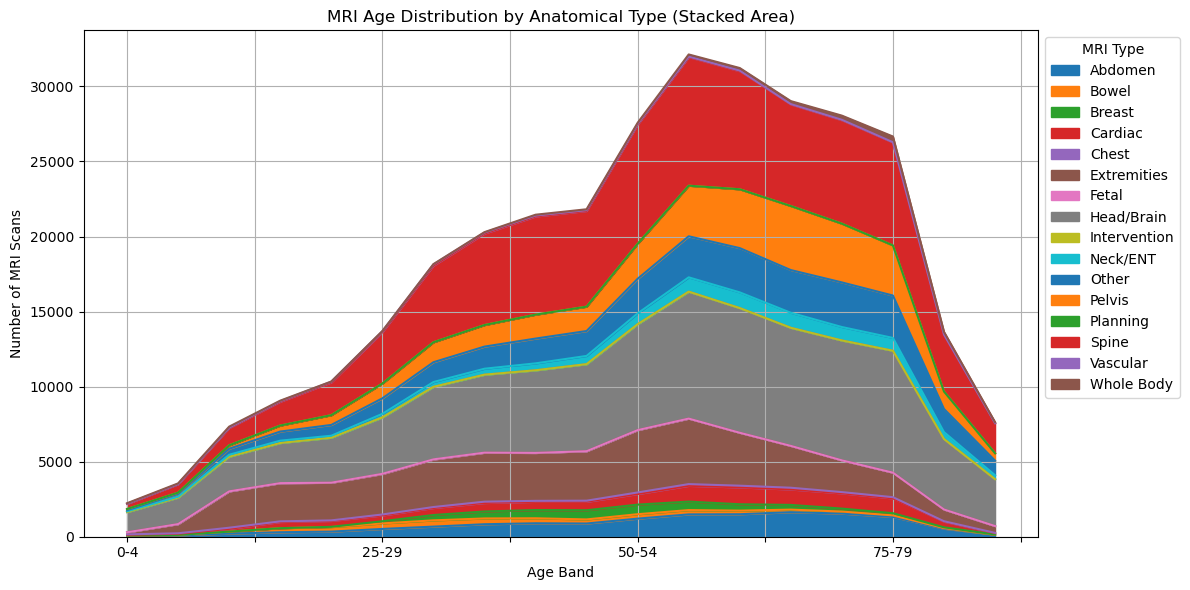

In [26]:
# ---------------------------------------------------
# Step 7a – MRI Scan Age Distribution by Type (Stacked Area Chart)
# ---------------------------------------------------

# Sort age bands in logical numeric order
sorted_bands = sorted(
    df_mri["age_band"].dropna().unique(),
    key=lambda x: int(str(x).split("-")[0].replace("+", ""))
)

# Crosstab: age_band × mri_type
mri_age_xtab = pd.crosstab(df_mri["age_band"], df_mri["mri_type"])
mri_age_xtab = mri_age_xtab.reindex(index=sorted_bands)

# Plot stacked area chart (absolute numbers)
fig, ax = plt.subplots(figsize=(12, 6))
mri_age_xtab.plot(kind="area", stacked=True, ax=ax)

ax.set_title("MRI Age Distribution by Anatomical Type (Stacked Area)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Number of MRI Scans")
ax.legend(title="MRI Type", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


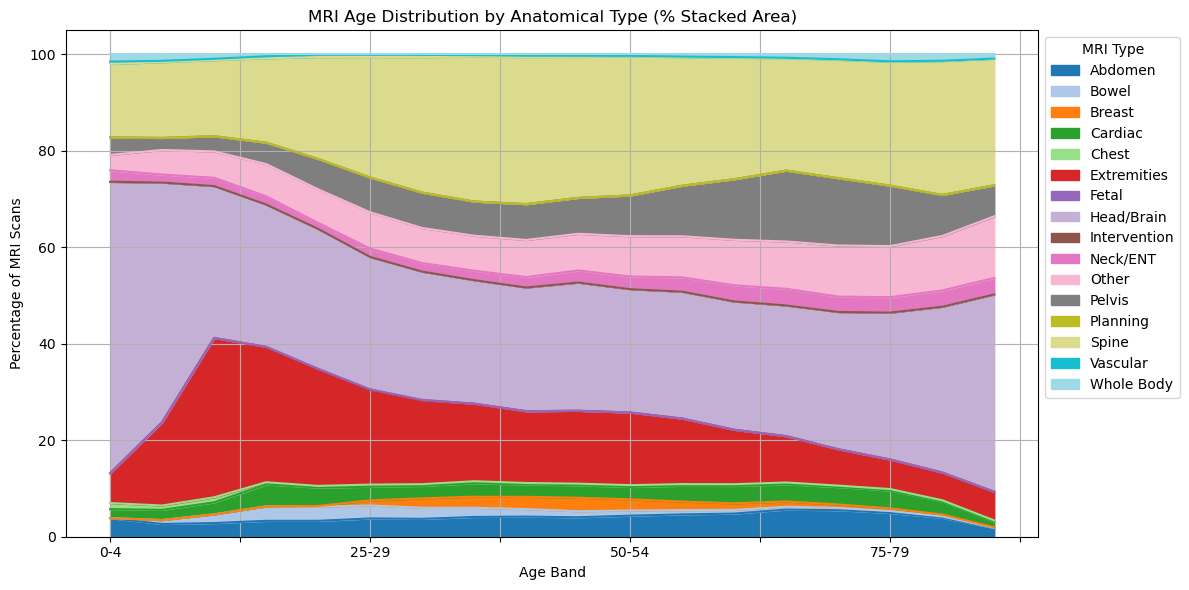

In [27]:
# ---------------------------------------------------
# Step 7b – MRI Scan Age Distribution by Type (% Stacked Area Chart)
# ---------------------------------------------------

# Compute percentage distribution across MRI types within each age band
mri_age_xtab_pct = mri_age_xtab.div(mri_age_xtab.sum(axis=1), axis=0) * 100

# Plot stacked area chart (percentages)
fig, ax = plt.subplots(figsize=(12, 6))
mri_age_xtab_pct.plot(kind="area", stacked=True, cmap="tab20", ax=ax)

ax.set_title("MRI Age Distribution by Anatomical Type (% Stacked Area)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Percentage of MRI Scans")
ax.legend(title="MRI Type", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


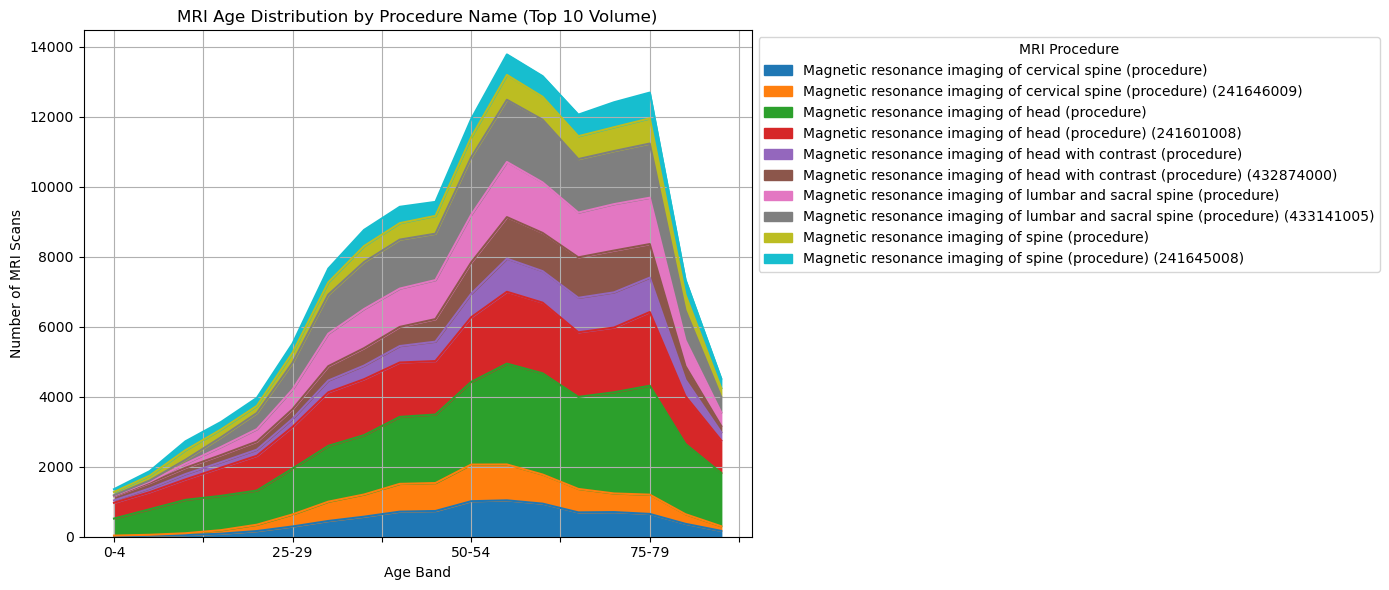

In [28]:
# ---------------------------------------------------
# Step 8a – MRI Scan Age Distribution by Procedure Name (Top 10 Only)
# ---------------------------------------------------

# Get top 10 most common MRI procedure names
top_10_mri_procs = df_mri["procedure_name"].value_counts().head(10).index.tolist()

# Crosstab of age_band × procedure_name for top 10 procedures
mri_proc_xtab = pd.crosstab(
    df_mri[df_mri["procedure_name"].isin(top_10_mri_procs)]["age_band"],
    df_mri[df_mri["procedure_name"].isin(top_10_mri_procs)]["procedure_name"]
)

# Reorder age bands numerically
sorted_bands = sorted(
    mri_proc_xtab.index.dropna(),
    key=lambda x: int(str(x).split('-')[0].replace('+', ''))
)
mri_proc_xtab = mri_proc_xtab.reindex(index=sorted_bands)

# Plot stacked area chart (absolute numbers)
fig, ax = plt.subplots(figsize=(14, 6))
mri_proc_xtab.plot(kind="area", stacked=True, ax=ax)

ax.set_title("MRI Age Distribution by Procedure Name (Top 10 Volume)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Number of MRI Scans")
ax.legend(title="MRI Procedure", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


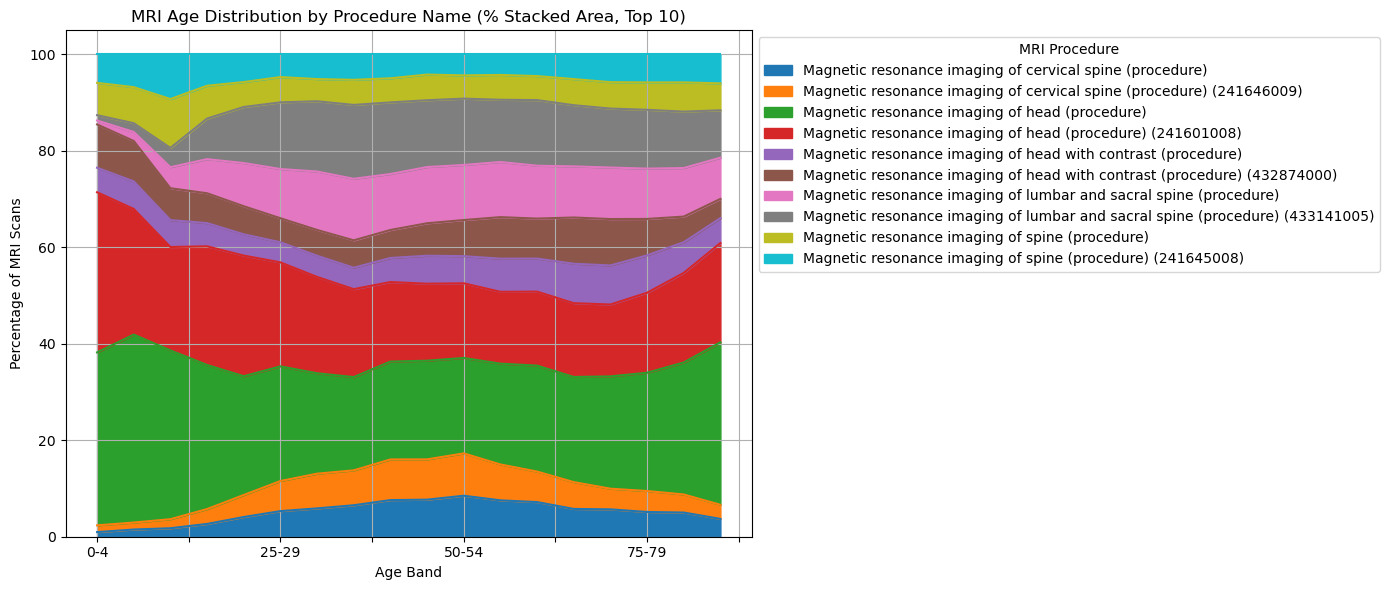

In [29]:
# ---------------------------------------------------
# Step 8b – MRI Scan Age Distribution by Procedure Name (% Stacked Area, Top 10)
# ---------------------------------------------------

# Convert to percentages
mri_proc_xtab_pct = mri_proc_xtab.div(mri_proc_xtab.sum(axis=1), axis=0) * 100

# Plot stacked area chart (percentage)
fig, ax = plt.subplots(figsize=(14, 6))
mri_proc_xtab_pct.plot(kind="area", stacked=True, cmap="tab10", ax=ax)

ax.set_title("MRI Age Distribution by Procedure Name (% Stacked Area, Top 10)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Percentage of MRI Scans")
ax.legend(title="MRI Procedure", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()
